# K-Means

In [800]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Importing dataset and doing basic EDA

In [801]:
df=pd.read_csv('clustering.csv')

In [802]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [803]:
df.shape

(381, 13)

In [804]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 13 columns):
Loan_ID              381 non-null object
Gender               376 non-null object
Married              381 non-null object
Dependents           373 non-null object
Education            381 non-null object
Self_Employed        360 non-null object
ApplicantIncome      381 non-null int64
CoapplicantIncome    381 non-null float64
LoanAmount           381 non-null float64
Loan_Amount_Term     370 non-null float64
Credit_History       351 non-null float64
Property_Area        381 non-null object
Loan_Status          381 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 38.8+ KB


In [805]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,381.000000,381.000000,381.000000,370.000000,351.000000
mean,3579.845144,1277.275381,104.986877,340.864865,0.837607
std,1419.813818,2340.818114,28.358464,68.549257,0.369338
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2600.000000,0.000000,90.000000,360.000000,1.000000
50%,3333.000000,983.000000,110.000000,360.000000,1.000000
75%,4288.000000,2016.000000,127.000000,360.000000,1.000000
max,9703.000000,33837.000000,150.000000,480.000000,1.000000


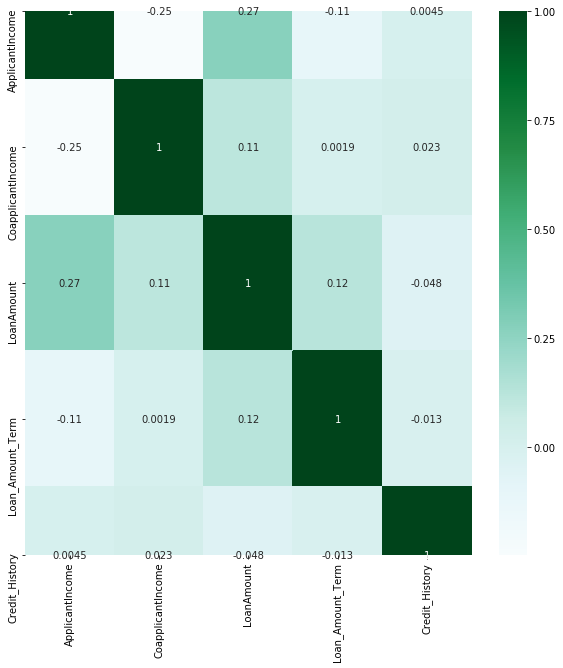

In [806]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,cmap='BuGn')

In [807]:
df.isna().sum()

Loan_ID               0
Gender                5
Married               0
Dependents            8
Education             0
Self_Employed        21
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     11
Credit_History       30
Property_Area         0
Loan_Status           0
dtype: int64

In [808]:
# Assuming that the missing values are of people who are not employed
df['Self_Employed'].fillna('No',inplace=True,axis=0)

In [809]:
# Everyone has a loan in this dataset so taking the median to replace the missing values
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median(),inplace=True,axis=0)

In [810]:
#Assuming missing credit history is no history    
df['Credit_History'].fillna(0,inplace=True,axis=0)

In [811]:
df.isna().sum()

Loan_ID              0
Gender               5
Married              0
Dependents           8
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

## Exploring and preprocessing main features selected for clustering 

(array([  5.,  34., 107., 118.,  64.,  26.,  14.,   9.,   1.,   3.]),
 array([ 150. , 1105.3, 2060.6, 3015.9, 3971.2, 4926.5, 5881.8, 6837.1,
        7792.4, 8747.7, 9703. ]),
 <a list of 10 Patch objects>)

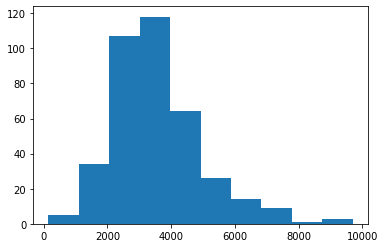

In [812]:
plt.hist(df['ApplicantIncome'])

(array([ 2.,  7., 13., 17., 30., 33., 69., 89., 76., 45.]),
 array([  9. ,  23.1,  37.2,  51.3,  65.4,  79.5,  93.6, 107.7, 121.8,
        135.9, 150. ]),
 <a list of 10 Patch objects>)

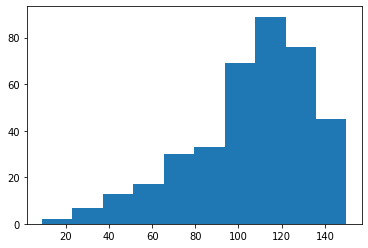

In [813]:
plt.hist(df['LoanAmount'])

#### The above features do not look very skewed and due to the small dataset I will avoid any transformation 

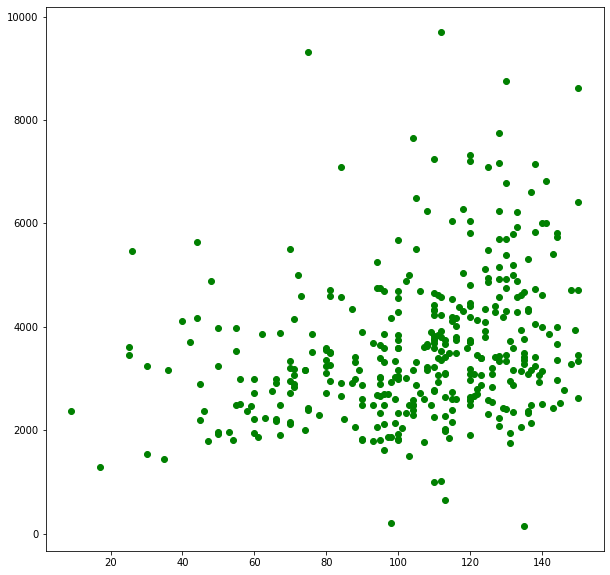

In [814]:
plt.figure(figsize=(10,10))
plt.scatter(x=df['LoanAmount'],y=df['ApplicantIncome'],c='g')

In [815]:
# Using standard scalar to scale the data
scaler = StandardScaler() 
scaler.fit(df[['LoanAmount','ApplicantIncome']])
df_scaled = pd.DataFrame(scaler.transform(df[['LoanAmount','ApplicantIncome']]))
df_scaled.columns =df[['LoanAmount','ApplicantIncome']].columns
df_scaled.describe()

,LoanAmount,ApplicantIncome
count,3.810000e+02,3.810000e+02
mean,-9.179009e-17,9.994921e-17
std,1.001315e+00,1.001315e+00
min,-3.389221e+00,-2.418877e+00
25%,-5.291748e-01,-6.910297e-01
50%,1.770094e-01,-1.740860e-01
75%,7.772660e-01,4.994218e-01
max,1.589378e+00,4.318317e+00


## K-Means Usings OOPS

In [816]:
class Kmeans:
    # Putting default paramenters as in scikit learn 
    def __init__(self,max_iter=300,k=2,max_tol=0.001):
        self.k=k
        self.tol=max_tol
        self.iter=max_iter
    
    # Fit Function 
    def fit(self,data):
        self.centroid={}
        
        # Initizling the orignal/Seed centroids as the first k points in the data 
        for i in range(self.k):
            self.centroid[i]=data[i]
        #print('Seed/Orignal Centroids: ',self.centroid)
        
        # Building the clusters 
        for loops in range(self.iter):
            self.classification={}
            
            #Setting all the classification for cluster in each iteration as an empty list 
            for i in range(self.k):
                self.classification[i]=[]
                
            #Finding the distance and allocating data point to cetroid
            for dp in data:
                distances=[self.caldistance(centroid,dp) for centroid in self.centroid]
                clusindex=distances.index(min(distances))
                self.classification[clusindex].append(dp)
            
            # Duplicating the centroids for stopping condition 
            old_centroids=dict(self.centroid)
            
            # This is to calculuate new centroids from the classified points
            for c,dp in self.classification.items():
                self.centroid[c]=np.mean(dp,axis=0)
                        
            # The stopping condition is in line with scikit learn ie if the percent change in centroids is less than the tolerance value then stop
            tolerance=0
            for i in self.centroid:
                current_centroid = self.centroid[i]
                prev_centroid = old_centroids[i]
                tolerance+=(np.sum((current_centroid - prev_centroid) / prev_centroid * 100.0))
                
            # Flag To break loop if the centroids are within tolerance
            flag=False
            if abs(tolerance) <= self.k*self.tol:
                flag = True
                
            if flag:
                break
                
    # Euclidian Distance / SSE
    def caldistance(self,k,dpoint):
        x1=dpoint[0]
        y1=dpoint[1]
        cent=self.centroid[k]
        distance=(cent[0]-x1)**2 + (cent[1]-y1)**2
        return distance
    
    # For Elbow Plot / SSE
    def inertia(self):
        SSE=0
        for centroid in self.centroid:
            SSEc=0
            for points in self.classification[centroid]:
                SSEc+=self.caldistance(centroid,points)
            SSE+=SSEc
        return SSE
            
    def predict(self,dp):
        distances=[self.caldistance(centroid,dp) for centroid in self.centroid]
        clusindex=distances.index(min(distances))
        return clusindex
    

## Finding the optimal K using Elbow Plot

In [817]:
X=np.array(df_scaled)

In [818]:
ss_error = {}
for i in range(1, 20):
    model = Kmeans(k=i)
    model.fit(X)
    ss_error[i] = model.inertia()

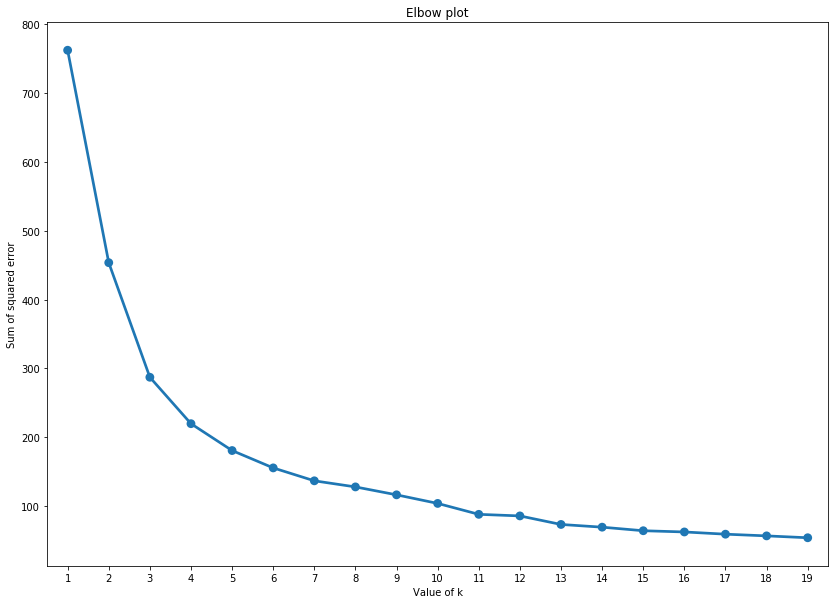

In [819]:
plt.figure(figsize = (14,10))
plt.title('Elbow plot')
plt.xlabel('Value of k')
plt.ylabel('Sum of squared error')
sns.pointplot(x=list(ss_error.keys()), y=list(ss_error.values()))

#### From visual observation K=4 seems like the best bet

## Fitting the Model

In [820]:
model=Kmeans(k=4)

In [821]:
model.fit(X)

In [822]:
model.centroid

{0: array([0.64727578, 0.26847799]),
 1: array([-1.49348144, -0.33755667]),
 2: array([ 0.12063337, -0.77035485]),
 3: array([0.7048821, 2.1198782])}

## Visualizing the clusters in 2-d Plane on the features 

In [823]:
def visualize(model):
    colors=['r','g','b','y']
    plt.figure(figsize=(10,10))
    for centroid in model.centroid:
        plt.scatter(model.centroid[centroid][0], model.centroid[centroid][1],marker="o", color="c", s=50, linewidths=5)

    for classification in model.classification:
        for featureset in model.classification[classification]:
            plt.scatter(featureset[0], featureset[1], marker="+", c=colors[classification], s=150, linewidths=5)     
    plt.xlabel('Loan Amount')
    plt.ylabel('Applicant Income')
    plt.show()

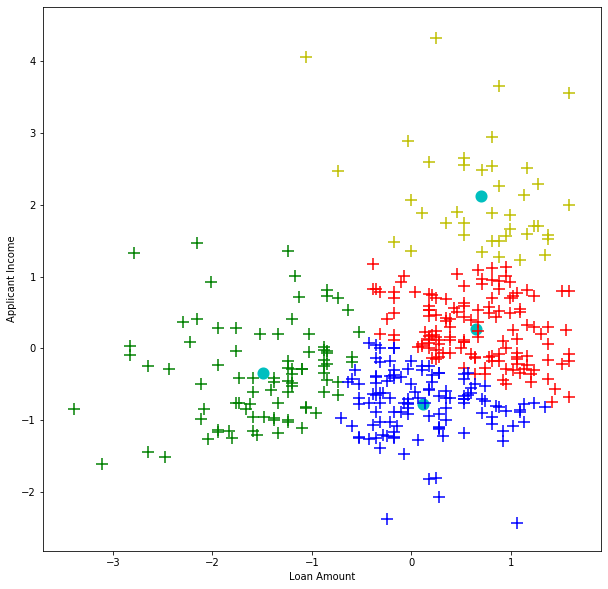

In [824]:
visualize(model)

## Using the Predict function to make a datafram with the orignal data

In [825]:
df_predict=df[['LoanAmount','ApplicantIncome']]

In [826]:
cluster=[]
for i in range(len(df_predict)):
    cluster.append(model.predict(np.array(df_scaled.iloc[i,:])))

In [827]:
clu=pd.DataFrame(cluster,columns=['Cluster'])

In [828]:
df_predict=pd.concat([df_predict,clu],axis=1)

In [829]:
df_predict.head(10)

,LoanAmount,ApplicantIncome,Cluster
0,128.0,4583,0
1,66.0,3000,1
2,120.0,2583,2
3,141.0,6000,3
4,95.0,2333,2
5,70.0,3200,1
6,109.0,2500,2
7,114.0,1853,2
8,17.0,1299,1
9,125.0,4950,0


In [830]:
df_predict.groupby(['Cluster']).agg({ 'LoanAmount':['mean', 'count'],'ApplicantIncome': ['mean', 'count']})

LoanAmount       ApplicantIncome      
               mean count            mean count
Cluster                                        
0        123.318519   135     3960.533333   135
1         62.689655    87     3101.206897    87
2        108.403361   119     2487.521008   119
3        124.950000    40     6585.725000    40

## Visualization with orignal(not scaled) features

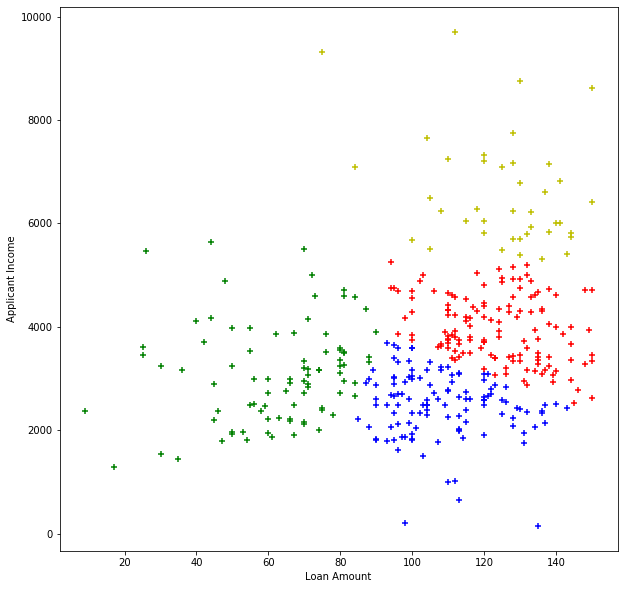

In [831]:
label={0:'r',1:'g',2:'b',3:'y'}
co=[label[i] for i in df_predict['Cluster']]
plt.figure(figsize=(10,10))
plt.scatter(x=df_predict['LoanAmount'],y=df_predict['ApplicantIncome'],c=co,marker='+')
plt.xlabel('Loan Amount')
plt.ylabel('Applicant Income')
plt.show()